In [1]:
import os
import numpy as np
import pywt
import random
import seaborn as sns
import tensorflow as tf
from keras.layers import Add
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import (
  Input, Conv1D, BatchNormalization, Activation, GlobalAveragePooling1D, 
  Dense, Dropout, GRU, Concatenate, LayerNormalization, MultiHeadAttention, 
  Reshape, Multiply, Softmax
)
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler
from matplotlib import pyplot as plt
from utils import (
  encode_labels, check_gpu_availability, plot_loss_accuracytupian, 
  evaluate_model, plot_confusion_matrixtupian, plot_tsne, 
  plot_precision_recall_curve_multiclasstupian, plot_roc_curve_multiclasstupian, 
  AdjustLearningRateCallback, denoise2,count_labels,denoise2_iterative2,AdjustLearningRateCallback
)
from utils import plot_precision_recall_curve_multiclass,plot_roc_curve_multiclass2,calculate_g_mean,plot_confusion_matrix,plot_confusion_matrix2,plot_loss_accuracy
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv1DTranspose


c:\ProgramData\anaconda3\envs\tensorflow\lib\site-packages\scipy\__init__.py:132: UserWarning: A NumPy version >=1.21.6 and <1.28.0 is required for this version of SciPy (detected version 1.20.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
check_gpu_availability()

GPU 可用


In [3]:
def denoise(data):
    # wavelet decomposition
    coeffs = pywt.wavedec(data=data, wavelet='db5', level=9)
    cA9, cD9, cD8, cD7, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

    # denoise using soft threshold
    threshold = (np.median(np.abs(cD1)) / 0.6745) * (np.sqrt(2 * np.log(len(cD1))))
    cD1.fill(0)
    cD2.fill(0)
    for i in range(1, len(coeffs) - 2):
        coeffs[i] = pywt.threshold(coeffs[i], threshold)

    # get the denoised signal by inverse wavelet transform
    rdata = pywt.waverec(coeffs=coeffs, wavelet='db5')
    return rdata

In [4]:
datafilename1 = "C:\\Users\\Administrator\\Desktop\\database\\cinc2017denoise.npz"
data1 = np.load(datafilename1, allow_pickle=True)
X_train, y_train, X_val, y_val, X_test, y_test = data1['ecgstrain'], data1['labelstrain'], data1['ecgsval'], data1['labelsval'], data1['ecgstest'], data1['labelstest']

In [5]:
y_train = encode_labels(y_train)
y_test = encode_labels(y_test)
y_val= encode_labels(y_val)
y_train = to_categorical(y_train, num_classes=4)
y_val=to_categorical(y_val, num_classes=4)
y_test = to_categorical(y_test, num_classes=4)

In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Reshape, GRU, Dense, Add, GlobalAveragePooling1D
from tensorflow.keras.models import Model


In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dropout, Dense
from tensorflow.keras.models import Model

def residual_block(x, filters, kernel_size, strides):
    shortcut = x
    # 主卷积路径
    x = Conv1D(filters, kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)

    # 如果shortcut的形状与x不匹配，则调整shortcut
    if shortcut.shape[-1] != x.shape[-1] or shortcut.shape[-2] != x.shape[-2]:
        shortcut = Conv1D(filters, 1, strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)

    # 添加跳过连接
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x


In [8]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Concatenate

def build_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv1D(32, 31, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # Residual blocks
    x = residual_block(x, 32, 31, 2)
    x = residual_block(x, 64, 17, 2)
    x_row = GRU(256, return_sequences=True)(x)
    x_row= Dropout(0.1)(x_row)
    x_col = GRU(256, return_sequences=True)(tf.transpose(x, [0, 2, 1]))
    x_col = Dropout(0.1)(x_col)
    x_col_pooled = GlobalAveragePooling1D()(x_col)
    x_dense = Dense(128, activation='relu')(x_col_pooled)
    outputs = Dense(num_classes, activation='softmax')(x_dense)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [9]:
model = build_model((4500, 1), 4)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 4500, 1)]    0                                            
__________________________________________________________________________________________________
conv1d (Conv1D)                 (None, 2250, 32)     1024        input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 2250, 32)     128         conv1d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 2250, 32)     0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [10]:
import tensorflow as tf

def weighted_crossentropy(weights):
    def loss(y_true, y_pred):
        # 计算未加权的交叉熵损失
        unweighted_loss = tf.keras.losses.CategoricalCrossentropy()(y_true, y_pred)
        # 应用类别权重
        weighted_loss = unweighted_loss * weights
        # 返回加权损失
        return weighted_loss
    return loss
class_weights = [2.0, 1.0, 1.5, 1.0] 

In [11]:
callback = AdjustLearningRateCallback(factor=0.1, patience=2, min_lr=1e-8)
early_stopping = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer='Adam', loss=weighted_crossentropy(class_weights), metrics=['accuracy'])
history=model.fit(X_train, y_train, batch_size=128, epochs=80, validation_data=(X_val, y_val), callbacks=[callback,early_stopping])

Epoch 1/80
55/55 [==============================] - 15s 88ms/step - loss: 1.2102 - accuracy: 0.6032 - val_loss: 1.8287 - val_accuracy: 0.3286
Epoch 2/80
55/55 [==============================] - 3s 61ms/step - loss: 0.9594 - accuracy: 0.6956 - val_loss: 1.5379 - val_accuracy: 0.3989
Epoch 3/80
55/55 [==============================] - 3s 60ms/step - loss: 0.8322 - accuracy: 0.7474 - val_loss: 1.5443 - val_accuracy: 0.4153
Epoch 4/80
55/55 [==============================] - 3s 61ms/step - loss: 0.7434 - accuracy: 0.7771 - val_loss: 1.4887 - val_accuracy: 0.4676
Epoch 5/80
55/55 [==============================] - 3s 61ms/step - loss: 0.6809 - accuracy: 0.7986 - val_loss: 1.9962 - val_accuracy: 0.3722
Epoch 6/80
55/55 [==============================] - 3s 61ms/step - loss: 0.5798 - accuracy: 0.8341 - val_loss: 0.8289 - val_accuracy: 0.7499
Epoch 7/80
55/55 [==============================] - 3s 61ms/step - loss: 0.4784 - accuracy: 0.8673 - val_loss: 1.2742 - val_accuracy: 0.6441
Epoch 8/80
5

In [12]:
evaluate_model(model,X_test,y_test)

Precision: 0.8679595602925027
Recall: 0.8661142609398811
F1 Score: 0.8666819236775375
Accuracy: 0.8443282381335478
Class 1 - Precision: 0.8298755186721992, Recall: 0.8810572687224669, F1 Score: 0.8547008547008548
Class 2 - Precision: 0.8906040268456376, Recall: 0.8840772818121253, F1 Score: 0.8873286526245402
Class 3 - Precision: 0.751358695652174, Recall: 0.7493224932249323, F1 Score: 0.7503392130257803
Class 4 - Precision: 1.0, Recall: 0.95, F1 Score: 0.9743589743589743
Class 1 Accuracy: 0.9726468222043443
Class 2 Accuracy: 0.8644408688656476
Class 3 Accuracy: 0.8519710378117458
Class 4 Accuracy: 0.999597747385358


In [13]:
y_pred_classes = np.argmax(model.predict(X_test), axis=-1)
y_test_classes = np.argmax(y_test, axis=1)

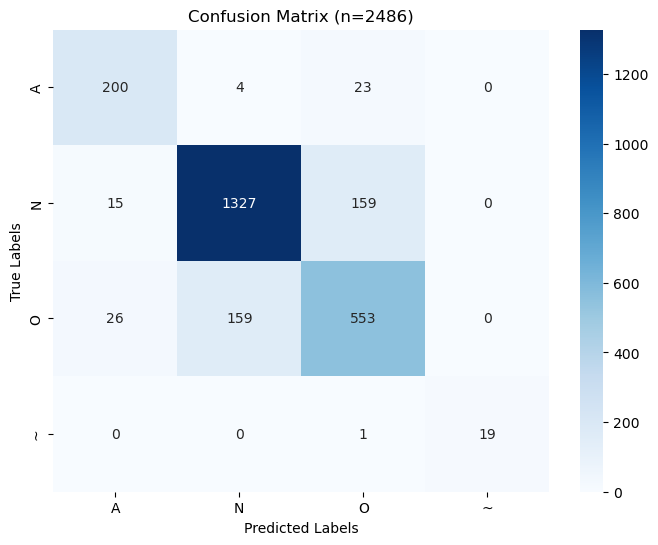

In [14]:
plot_confusion_matrix2(y_test_classes, y_pred_classes, classes=['A', 'N', 'O', '~'])